In [1]:
import os
import torch
from LatentPixel import LatentGPT2, LPixelForMLM, TGraph, LPixelForClassification, Discriminator, DiscriminatorConfig
from LatentPixel.metrics import Metric
from LatentPixel.training import ExpConfig
from LatentPixel import get_glue_dataset, GLUE_META
from LatentPixel import RenderConfig
from dataclasses import dataclass, field, asdict
from collections import defaultdict
from train import get_config
from sklearn.metrics import matthews_corrcoef
from tqdm import tqdm

_ = TGraph.init_render(dpi=180, pixels_per_patch=24)
text = 'Alice was everywhere, until she wasn’t. Just like at first, she was nowhere until she was. The absence of her before I knew she existed, was nothing. Now, the absence of her shrouds everything. Like a guest who never came to dinner; a stormy sky that didn’t deliver. Nothing can wash away the void where she used to be. This is what I’m thinking about the first time I take The Walk without her. I met Alice at a dinner party, the raucous kind with wild guests, beautiful people glittering in late summer air on a second-floor balcony backlit by a September sky. We were all friends of Richard, and this was his brilliant attempt to make all the people I love come together. Or it was a lavish birthday party thrown for himself. You could never quite tell with Richard. He was my hairdresser, but I was included among the people he loved the most, and so was Alice. From across the table, her eyes kept locking mine with interest: hers large and dark and layered with mischief. Her husband was older, serene. A balm to her boisterousness.'
story = 'This is a story about a knight who'
repeat = 'this this this this this this this this this'  * 10

In [3]:
from datasets import load_dataset

dataset = load_dataset("bookcorpusopen")

AttributeError: module 'threading' has no attribute '_Condition'

In [2]:
from datasets import interleave_datasets, load_dataset, load_from_disk,save_to_disk
ds = load_dataset("bookcorpus")

AttributeError: module 'threading' has no attribute '_Condition'

In [2]:
vagpt = LatentGPT2(
    coder_path=None,
    backbone_path='storage/checkpoints/24D_gpt2_2_gan_/lpixel_pretrain/LatentGPT2/20230816-030123/29000/backbone',
    img_size=(3, 24, 24*529),
    latent_size=(3, 24, 24*529)
)

Coder path is none, do not load coder for this model


Some weights of GPT2ForPatchCausalInference were not initialized from the model checkpoint at storage/checkpoints/24D_gpt2_2_gan_/lpixel_pretrain/LatentGPT2/20230816-030123/29000/backbone and are newly initialized: ['wte.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model = LatentGPT2(
    coder_path=None,
    backbone_path='storage/checkpoints/24D_gpt2_2_gan26_/lpixel_pretrain/LatentGPT2/20230817-230603/20000/backbone',
    img_size=(3, 24, 24*529),
    latent_size=(3, 24, 24*529)
)

Coder path is none, do not load coder for this model


Some weights of GPT2ForPatchCausalInference were not initialized from the model checkpoint at storage/checkpoints/24D_gpt2_2_gan26_/lpixel_pretrain/LatentGPT2/20230817-230603/20000/backbone and are newly initialized: ['wte.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
real = TGraph.from_text([text])

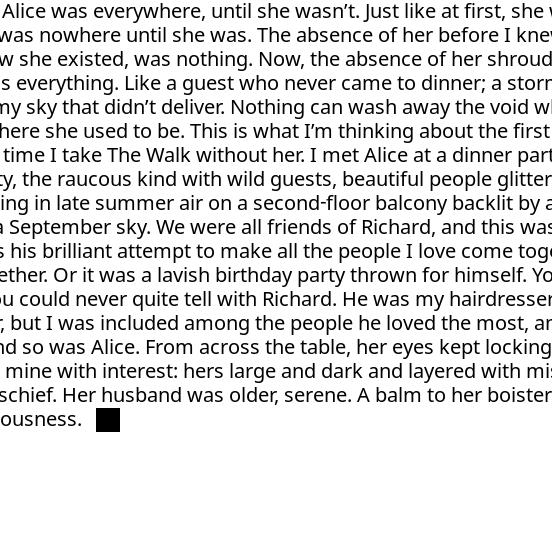

In [4]:
# real.circle_mask(mask=real.attention_mask)
real.squarelize().to_PIL()[0]

In [15]:
with torch.no_grad():
    gen = vagpt.autoregressive_generate(real.unsquarelize(), 13, 600)

generate the 0 th patch
generate the 1 th patch
generate the 2 th patch
generate the 3 th patch
generate the 4 th patch
generate the 5 th patch
generate the 6 th patch
generate the 7 th patch
generate the 8 th patch
generate the 9 th patch
generate the 10 th patch
generate the 11 th patch
generate the 12 th patch
generate the 13 th patch
generate the 14 th patch
generate the 15 th patch
generate the 16 th patch
generate the 17 th patch
generate the 18 th patch
generate the 19 th patch
generate the 20 th patch
generate the 21 th patch
generate the 22 th patch
generate the 23 th patch
generate the 24 th patch
generate the 25 th patch
generate the 26 th patch
generate the 27 th patch
generate the 28 th patch
generate the 29 th patch
generate the 30 th patch
generate the 31 th patch
generate the 32 th patch
generate the 33 th patch
generate the 34 th patch
generate the 35 th patch
generate the 36 th patch
generate the 37 th patch
generate the 38 th patch
generate the 39 th patch
generate t

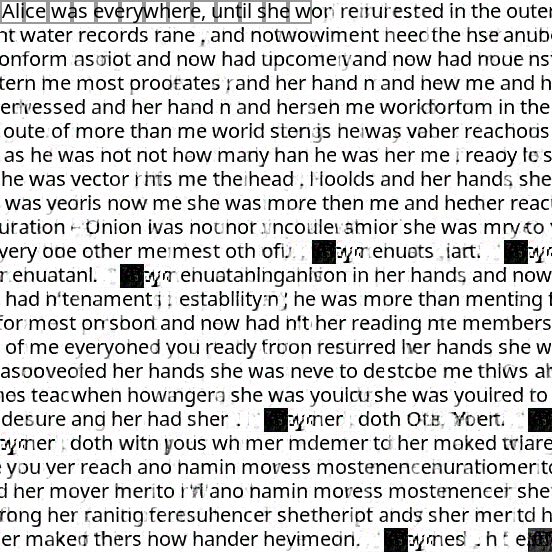

In [14]:
gen.squarelize().to_PIL()[0]

In [12]:
copy = TGraph()
copy._value = torch.clone(gen.value)
copy.attention_mask = gen.attention_mask

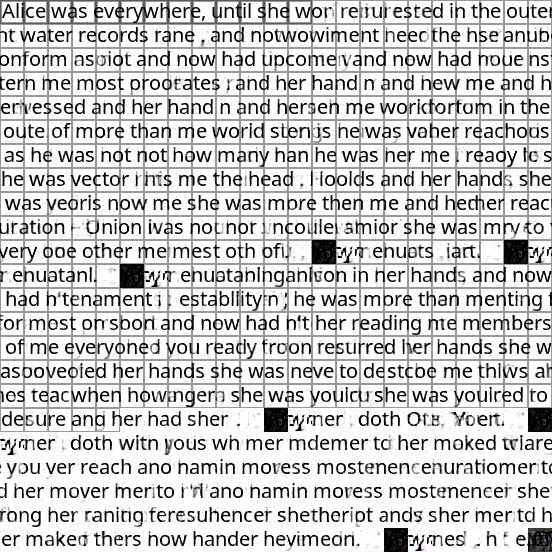

In [13]:
copy.circle_mask('black', 0.4, width=1, mask=gen.attention_mask)
copy.squarelize().to_PIL()[0]

In [28]:
with torch.no_grad():
    gen = model.autoregressive_generate(real, 13, 600)

generate the 0 th patch
generate the 1 th patch
generate the 2 th patch
generate the 3 th patch
generate the 4 th patch
generate the 5 th patch
generate the 6 th patch
generate the 7 th patch
generate the 8 th patch
generate the 9 th patch
generate the 10 th patch
generate the 11 th patch
generate the 12 th patch
generate the 13 th patch
generate the 14 th patch
generate the 15 th patch
generate the 16 th patch
generate the 17 th patch
generate the 18 th patch
generate the 19 th patch
generate the 20 th patch
generate the 21 th patch
generate the 22 th patch
generate the 23 th patch
generate the 24 th patch
generate the 25 th patch
generate the 26 th patch
generate the 27 th patch
generate the 28 th patch
generate the 29 th patch
generate the 30 th patch
generate the 31 th patch
generate the 32 th patch
generate the 33 th patch
generate the 34 th patch
generate the 35 th patch
generate the 36 th patch
generate the 37 th patch
generate the 38 th patch
generate the 39 th patch
generate t

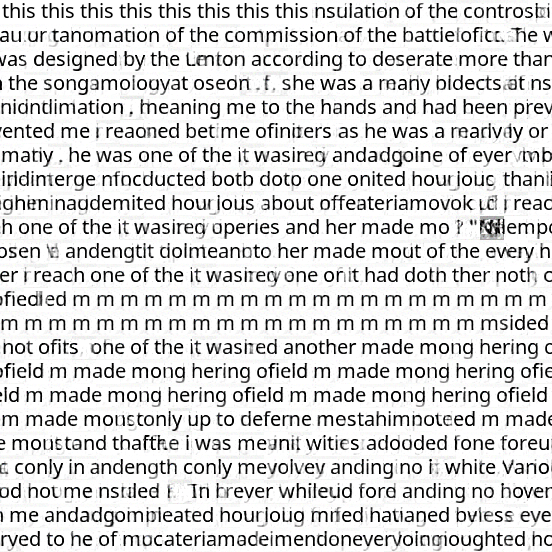

In [29]:
gen.squarelize().to_PIL()[2]

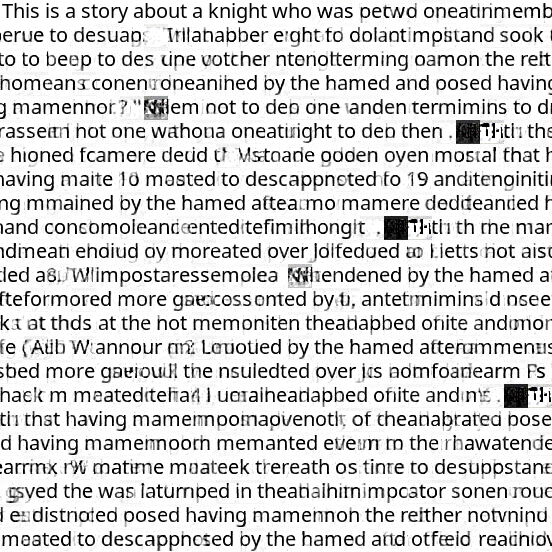

In [30]:
gen.squarelize().to_PIL()[1]

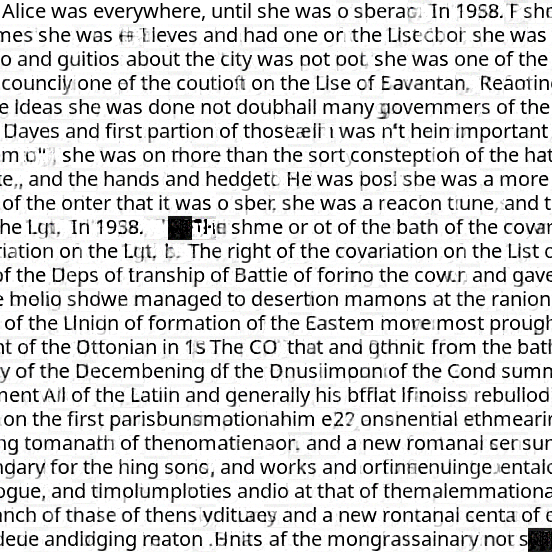

In [31]:
gen.squarelize().to_PIL()[0]

In [9]:
model.backbone.in_proj.weight.shape

torch.Size([768, 3, 24, 24])

In [12]:
for parm in model.backbone.in_proj.parameters():
    print(parm.shape)

torch.Size([768, 3, 24, 24])


In [15]:
embeddings = model.backbone.in_proj(real.unsquarelize().value)

In [16]:
embeddings.shape

torch.Size([2, 768, 1, 529])

In [36]:
embeddings[0, 1, 0, 0]

tensor(-2.7515, grad_fn=<SelectBackward0>)

In [23]:
first_patch = real.value[0, :, :, :24]

In [24]:
first_patch.shape

torch.Size([3, 24, 24])

In [25]:
fembedding = model.backbone.in_proj(first_patch)
fembedding.shape

torch.Size([768, 1, 1])

In [26]:
fembedding[0, 0, 0]

tensor(-0.6209, grad_fn=<SelectBackward0>)

In [27]:
proj = model.backbone.in_proj.weight * first_patch

In [28]:
proj.shape

torch.Size([768, 3, 24, 24])

In [31]:
proj.sum([1, 2, 3]).shape

torch.Size([768])

In [37]:
proj.sum([1, 2, 3])[0]

tensor(-0.6209, grad_fn=<SelectBackward0>)

In [55]:
def check(s, p) -> bool:
    for c in s:
        if c not in p and '.' not in p:
            return False
        
    for idx in range(len(p)):
        if p[idx] not in s and (idx == len(p) - 1 or (idx < len(p) - 1 and p[idx + 1] != '*')) and p[idx] != '*' and p[idx] != '.':
            print('here', p[idx])
            return False        
    
    return True

def match(s: str, sidx: int, p: str, pidx: int, prep: str) -> bool:
    global b
    if b:
        return False
    # print(s, sidx, p, pidx, prep)
    if sidx == len(s):
        if pidx == len(p):
            return True
        if p[pidx] == '*':
            return match(s, sidx, p, pidx + 1, None)
        if pidx < len(p) - 1 and p[pidx + 1] == '*':
            return match(s, sidx, p, pidx + 1, p[pidx])
        return False

    if pidx == len(p):
        return False

    if p[pidx] == '*':
        if s[sidx] == prep or prep == '.':
            if match(s, sidx + 1, p, pidx, prep):
                return True
        return match(s, sidx, p, pidx + 1, None)
    
    if pidx < len(p) - 1 and p[pidx + 1] == '*':
        if s[sidx] == p[pidx] or p[pidx] == '.':
            if match(s, sidx + 1, p, pidx + 1, p[pidx]):
                return True
        return match(s, sidx, p, pidx + 1, p[pidx])
    
    if s[sidx] == p[pidx] or p[pidx] == '.':
        return match(s, sidx + 1, p, pidx + 1, p[pidx])
    
    if s[sidx] not in p and '.' not in p:
        b = True
        return False

    return False 

class Solution:
    def isMatch(self, s: str, p: str) -> bool:
        if not check(s, p):
            return False
        global b 
        b = False
        return match(s, 0, p, 0, None)



In [56]:
Solution().isMatch('mississippi', 'mis*is*ip*.')

True

In [5]:
a = [1, 2, 3, 1]
a.sort(reverse=True)

In [6]:
a

[3, 2, 1, 1]

In [16]:
def subsetA(arr):
    # Write your code here
    arr.sort(reverse=True)
    s = sum(arr)

    a_sum = 0
    for idx, num in enumerate(arr):
        a_sum += num
        if a_sum > s - a_sum:
            break

    return arr[:idx + 1].reverse()


In [17]:
subsetA([5, 3, 2, 4, 1, 2])

In [35]:
def getMinSize(arr):
    # Write your code here
    if len(arr) == 0:
        return 0
    arr.sort()
    onum = len(arr)
    dnum = 0
    could_delet = []
    could_remain = []
    for n in arr:
        if 2 * n <= arr[-1]:
            could_delet.append(n)
        else:
            could_remain.append(n)

    print(could_delet, could_remain)
    
    didx = len(could_delet) - 1
    ridx = len(could_remain) - 1

    while True:
        if didx < 0 or ridx < 0:
            break

        tod = could_delet[didx]
        tor = could_remain[ridx]

        if 2 * tod <= tor:
            dnum += 1
            didx -= 1
            ridx -= 1
        else:
            didx -= 1
            
    return onum - dnum

In [36]:
getMinSize([4, 4, 6, 7, 8])

[4, 4] [6, 7, 8]


4

In [37]:
3 // 2

1

In [39]:
1 // 2

0

In [45]:
def bin(arr, l, r, x):
    if r >= l:
        mid = l + (r - l) // 2
        if arr[mid] == x:
            return mid
        if  arr[mid] > x:
            return bin(arr, l, mid , x)
        return bin(arr, mid + 1, r, x)
    return -1

In [46]:
bin([1, 2, 3, 4, 5], 0, 4, 1)

0

In [52]:
def getMinimumChanges(fileSize, minSize):
    # Write your code here
    lacking = 0
    exceed = []
    ops = 0
    for fs, ms in zip(fileSize, minSize):
        if fs > ms:
            exceed.append(fs - ms)
        elif fs < ms:
            lacking += ms - fs
            ops += 1
    
    exceed.sort(reverse=True)

    for e in exceed:
        ops += 1
        lacking -= e
        if lacking <= 0:
            break
    
    if lacking > 0:
        return -1

    return ops

In [53]:
getMinimumChanges([4, 1, 5, 2, 3], [3, 2, 2, 1, 4])

3

In [54]:
a = [4, 1, 5, 2, 3]
a.sort(reverse=True)
a

[5, 4, 3, 2, 1]

In [1]:
def fib(n: int) -> int:
    if n == 0:
        return 0
    if n == 1:
        return 1
    results = [0] * n
    results[0] = 0
    results[1] = 1
    if n > 1:
        for i in range(2, n):
            results[i] = results[i - 1] + results[i - 1]

    return results[n - 1]

In [7]:
fib(1000000000)

: 

In [8]:
class Solution:
    def longestCommonSubsequence(self, text1: str, text2: str) -> int:
        cache = [[0 for _ in range(len(text2) + 1)] for _ in range(len(text1) + 1)]
        for i in range(1, len(text1) + 1):
            for j in range(1, len(text2) + 1):
                if text1[i - 1] == text2[j - 1]:
                    cache[i][j] = cache[i - 1][j - 1] + 1
                else:
                    cache[i][j] = max(cache[i - 1][j], cache[i][j - 1])
        return cache[-1][-1]

In [9]:
Solution().longestCommonSubsequence('abcde', 'ace')

[[0, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 1], [0, 1, 2, 2], [0, 1, 2, 2], [0, 1, 2, 3]]


3

In [ ]:
class Solution:
    def shortestCommonSupersequence(self, str1: str, str2: str) -> str:
        dp = [[0 for _ in range(len(str1) + 1)] for _ in range(len(str2) + 1)]
        for i in range(1, len(str1) + 1):
            for j in range(1, len(str2) + 1):
                if str1[i - 1][j - 1] == str2[i - 1][j - 1]:
                    dp[i][j] = dp[i - 1][j - 1] + 1
                else:
                    dp[i][j]

In [32]:
class Solution:
    def shortestCommonSupersequence(self, str1: str, str2: str) -> str:
        prev = ['' for _ in range(len(str2) + 1)]
        curt = ['' for _ in range(len(str2) + 1)]
        for i in range(1, len(str1) + 1):
            for j in range(1, len(str2) + 1):
                if str1[i - 1] == str2[j - 1]:
                    curt[j] = prev[j - 1] + str2[j - 1]
                elif len(prev[j]) > len(curt[j - 1]):
                    curt[j] = prev[j]
                else:
                    curt[j] = curt[j - 1]
            tmp = prev
            prev = curt
            curt = tmp

        lcs = prev[-1]
        result = ''
        idx1 = 0 
        idx2 = 0
        idxc = 0
        print(lcs)
        while idxc < len(lcs):
            while str1[idx1] != lcs[idxc]:
                result += str1[idx1]
                idx1 += 1
            while str2[idx2] != lcs[idxc]:
                result += str2[idx2]
                idx2 += 1
            result += lcs[idxc]
            idxc += 1
            idx1 += 1
            idx2 += 1
        result += str1[idx1:] + str2[idx2:]

        return result

In [2]:
((10200 + 1900) / 2) - 1900

4150.0

In [4]:
def max3(nums: list[int]) -> int | None:
    ones = []
    twos = []
    zeros = []
    total = 0
    
    for num in nums:
        left = num % 3
        if left == 0:
            zeros.append(num)
        elif left == 1:
            ones.append(num)
        else:
            twos.append(num)
        total += num
        
    ones.sort(reverse=True)
    twos.sort(reverse=True)
    
    left = total % 3
    if left == 1:
        if len(ones) > 0:
            ones.pop()
        elif len(twos) > 1:
            twos.pop()
            twos.pop()
        else:
            return None
    elif left == 2:
        if len(twos) > 0:
            twos.pop()
        elif len(ones) > 1:
            ones.pop()
            ones.pop()
        else:
            return None
        
    nums = ones + twos + zeros
    nums.sort(reverse=True)
    
    result = ''
    for num in nums:
        result += str(num)
        
    return int(result)
    
        

In [5]:
max3([4, 7, 3, 3])

33

In [1]:
for i in range(1, 5):
    print(i)

1
2
3
4


In [1]:
def advance(pointers: list[int], length: int) -> bool:
  ppointer = -1

  while True:
    if pointers[ppointer] < length + ppointer:
      pointers[ppointer] += 1
      break
    if ppointer + len(pointers) == 0:
      return False
    ppointer -= 1

  pidx = ppointer + 1
  while pidx != 0:
    pointers[pidx] = pointers[pidx - 1] + 1
    pidx += 1

  return True

In [1]:
pos = [1, 2]


In [49]:
print(advance(pos, 5))
print(pos)

False
[3, 4]


In [2]:
print(pos)

[1, 2]


In [1]:
from LatentPixel import CNNAutoencoderConfig, CNNAutoencoder, TGraph

_ = TGraph.init_render(max_seq_length=2*2*3*4*5*6, patch_len=5)
print(2*2*3*4*5*6)

1440


In [2]:
net = CNNAutoencoder('storage/autoencoders/r4h4c3r1')

In [3]:
pnum = 0
for param in net.parameters():
    pnum += param.numel()
print(pnum)

1789959


In [17]:
batch = TGraph.from_text(['W' * 2000])

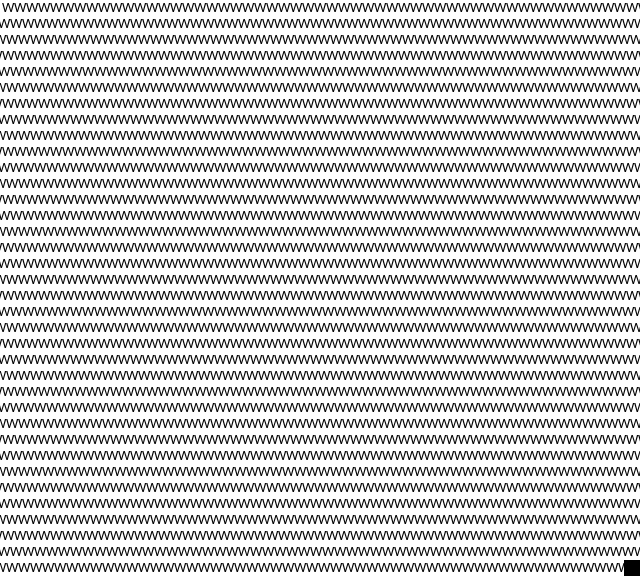

In [18]:
batch.to_PIL()[0]

In [15]:
batch.to_file('test')

In [16]:
result.loss

NameError: name 'result' is not defined

In [11]:
codes = net.encode(batch)

In [12]:
codes.value.shape

torch.Size([2, 4, 4, 2880])

In [27]:
batch.patch_len

1

In [34]:
class A:
    val = 0

In [35]:
a = A()
print(a.val)
a.val = 3
print(a.val)

print(A.val)
A.val = 3
print(A.val)
b = A()
print(b.val)

0
3
0
3
3


In [39]:
batch.patch_len

5

In [37]:
TGraph.patch_len = 5

In [41]:
net.patch_len

1

In [9]:
img = torch.randn([32, 3, 16, 10000])

NameError: name 'torch' is not defined

In [15]:
batch: TGraph
batch.max_seq_len

AttributeError: 'TGraph' object has no attribute 'max_seq_len'